# Figure 3) Energy Supply - Example Model
Here we create Figure 3 in Trinh+ (2026), which shows the results of fluid mixing or an individual model. The subplots all in terms of $T_{mix}$ and are organized as follows:
- a) mass ratio
- b) pH and log fO2
- c) molality of aqueous species
- d) energy supply

While this notebook is currently set to plot the nominal model, it can be easily adjusted to plot other models too, which we explain at the end of this notebook.

First, let's load AqEquil and the necessary Python libraries.

In [1]:
import numpy as np
import aqequil
import pandas as pd
import matplotlib.pyplot as plt
import pychnosz
import pickle

# load database and AqEquil
ae = aqequil.AqEquil(db='kev', 
                     suppress_redox=["C"],
                     exclude_organics=True,
                     )

Loading a user-supplied thermodynamic database...
data1.kev was not found in the EQ36DA directory but a data0.kev was found in the current working directory. Using it...
data0.kev is now set as the active thermodynamic database.


Next, we define helper functions whose purpose is written in their respective docstrings.

In [2]:
def getDF(filename):
    '''Obtain DataFrame of energy supply and solute concentration data for a 
    given mixture. The "filename" is a list of mixture objects, and "i_nom" is the 
    index of the desired mixture.'''
    # open file of fluid mixing
    with open (filename, 'rb') as file:
        mixture = pickle.load(file)
    
    # obtain energy supply DataFrame
    df_E = mixture.plot_energy(y_type = "E",
            y_units = "cal",
            x_type='temperature',
            show_zero_line = True,
            species = ["CO2", "H2", "CH4", "H2O"],
            stoich = [-1, -4, 1, 2],
            df_out = True,)
    df_E = df_E[1]

    # translate Xi to fluid mass ratio
    df1 = df_E[df_E['Xi']<=1] # values where vent fluid < seawater mass
    tmp1 = 1/np.array(df1['Xi'].tolist()[1:])
    tmp1C = df1['Temp(C)'].tolist()[1:]
    
    df2 = df_E[df_E['Xi']>=1] # values where vent fluid > seawater mass
    tmp2 = 2-np.array(df2['Xi'].tolist())
    tmp2C = df2['Temp(C)']

    mass_ratios = tmp1.tolist() + tmp2.tolist() # kg of seawater added to vent fluid

    # obtain aqueous species DataFrame
    sp = ['CO2', 'CH4', 'H2', 'HCO3-', 'H+']
    df_aq = mixture.aq_distribution_logmolal[sp]

    # compute minimum energy supply
    Alim = 10.6e3 # minimum energy supply for methanogens (J / mol CH4) (Hoehler+, 2001)
    J2cal = 0.2390 # calories in a joule
    H2_molality = 10**df_aq['H2'] # concentration of H2 (molal)
    Emin = Alim*J2cal*H2_molality/4

    # specify columns of interest
    tmp_data = {'Xi': df_E['Xi'],
              'Mass ratio': mass_ratios,
              'Temp(C)': df_E['Temp(C)'],
              'Press(bars)': df_E['Press(bars)'],
              'pH': df_E['pH'],
              'log fO2': df_E['log fO2'],
              'CO2': df_aq['CO2'],
              'CH4': df_aq['CH4'], 
              'H2': df_aq['H2'],
              'HCO3-': df_aq['HCO3-'],
              'H+': df_aq['H+'],
              'E (cal/kg fluid)': df_E['E, cal/kg fluid'],
              'Emin (cal/kg fluid)': Emin
             }
    df = pd.DataFrame(tmp_data)
    return df

def getNeutralpH(dataframe):
    # determine neutral pH
    data_pH = pychnosz.subcrt(
            species = ['H2O', 'H+', 'OH-'],
            state = ['liq', 'aq', 'aq'],
            coeff = [-1, 1, 1],
            T = dataframe['Temp(C)'].tolist(),
            P = dataframe['Press(bars)'].tolist(),
            property="logK",
            messages=False,
            show=False,
            ).out
    pH_neutral = -0.5 * data_pH.logK
    return pH_neutral

def getMR(T1, Tmix, T2):
    '''Get fluid mass ratio between cold reservoir (T1) and hot reservoir (T2).'''
    m2 = 1
    m1 = (T2-Tmix)/(Tmix-T1) * m2
    return m1 / m2

def mr2Tmix(T1, mr, T2):
    '''Get the temperature of the mixed fluid given a mass ratio between temperatures T1 and T2.'''
    return (mr*T1+T2)/(mr+1)

def energyRequired(filename):
    '''Calculate the minimum amount of energy required to sustain methanogens. Since Hoehler+ (2001) reports the 
    minimum energy limit in units of "J / mole of CH4", we estimate the minimum energy required based on the CH4 
    concentration of our mixed fluid. Perform unit conversions as necessary.'''
    # load data from pickle file
    with open (filename, 'rb') as file:
        mixture = pickle.load(file)

    # calculate logK of methanogenesis
    _, df_logK = mixture.plot_energy(species=["CO2", "H2", "CH4", "H2O"],
               stoich=[-1, -4, 1, 2],
               x_type="temperature",
               y_type="logK",
               show_zero_line=False,
               df_out=True,
               )

    # get log activities of CO2, H2, CH4, and equil aCH4
    df_actual_molal = mixture.aq_distribution_logact[["CO2", "H2", "CH4"]]
    df_actual_molal = df_actual_molal.rename(columns={'CO2':'CO2_actual','H2':'H2_actual', 'CH4': 'CH4_actual'})
    df = pd.concat([df_logK, df_actual_molal], axis=1)
    logK = df['logK']
    logaCO2 = df['CO2_actual']
    logaH2 = df['H2_actual']
    df['equilibrium logaCH4'] = logK + logaCO2 + 4 * logaH2

    # calculate the difference between actual and equilibrium of CH4
    df['delta CH4 (molal)'] = 10**df['CH4_actual'] - 10**df['equilibrium logaCH4']

    # calculate the max minimum-energy limit for methanogenesis
    Alim_kJpermol = 10.6 # kJ / mol of CH4 produced (Hoehler et al., 2001)
    Alim_calpermol = Alim_kJpermol*1000/4.184 # cal / mol of CH4 produced
    deltaCH4 = df['delta CH4 (molal)'] # mol CH4 produced (versus equilibrium) per kg fluid
    df["E_lim"] = Alim_calpermol * deltaCH4
    df.loc[df["E_lim"] < 0, "E_lim"] = 0
    return df['E_lim']

def makeFigure3(filename, include_labels=True):
    '''Plot the mixed fluid temperature, oxygen fugacity, pH, composition, and energy supply of a fluid mixture.'''
    df = getDF(filename) # get nominal model data
    E_lim = energyRequired(filename)

    # create figure skeleton
    fsize = (4, 10)
    fs = 8 # font size
    fig, axes = plt.subplots(4, 1, figsize=fsize)
    ax0, ax1, ax2, ax3 = axes

    # independently determine T_mix vs fluid mass ratio
    T1 = min(df['Temp(C)'])
    T2 = max(df['Temp(C)'])
    Tmix_arr = np.linspace(T1, T2, 100)
    mmix_arr = getMR(T1, Tmix_arr[1:], T2)

    # Plot Figure 3a) T_mix vs. fluid mass ratio (do this independent of EQ6)
    color_mr='black'
    ax0.plot(Tmix_arr[1:], mmix_arr, c=color_mr)
    ax0.plot([0, max(df['Temp(C)'])], [0, 0], 'k--')
    ax0.axvspan(122, T2, facecolor='black', alpha=0.1)
    ax0.set_xticklabels([])
    ax0.tick_params(top=True, axis='both', labelsize=8)
    ax0.set_xlim([0, T2])
    ax0.set_ylim([-2, max(mmix_arr)])

    # Plot Figure 3b) T_mix vs. pH and log fO2
    color_pH, color_fO2 = 'black', 'tab:blue'
    pH_neutral = getNeutralpH(df)
    ax1a = ax1
    ax1a.plot(df['Temp(C)'], df['pH'], color=color_pH)
    ax1a.plot(df['Temp(C)'], pH_neutral, color=color_pH, linestyle='--')
    ax1a.tick_params(top=True, axis='y', labelcolor=color_pH)
    ax1a.set_xlim([0, T2])
    ax1a.set_xticklabels([])
    
    ax1b = ax1a.twinx()  # instantiate a second Axes that shares the same x-axis
    ax1b.plot(df['Temp(C)'], df['log fO2'], color=color_fO2)
    ax1b.tick_params(top=True, axis='y', labelcolor=color_fO2)
    ax1b.tick_params(top=True, axis='both', labelsize=8)
    ax1b.axvspan(122, T2, facecolor='black', alpha=0.1)

    # Plot Figure 3c) log molality of various species
    sp = ['CO2', 'CH4', 'H2', 'HCO3-', 'H+']
    sp_leg = [r'$CO_2$', r'$CH_4$', r'$H_2$', r'$HCO3^-$', r'$H^+$']
    for j in range(len(sp)):
        solute = sp[j]
        ax2.plot(df['Temp(C)'], df[solute], linewidth=1)
    ax2.set_xlim([0, T2])
    ax2.set_ylim([-12, 2])
    ax2.set_xticklabels([])
    ax2.tick_params(top=True, axis='both', labelsize=8)
    ax2.axvspan(122, T2, facecolor='black', alpha=0.1)

    # Plot Figure 3d) Energy supply for the nominal model
    eng = 'E (cal/kg fluid)'
    mr_pick = [1, 10, 20, 50] # pick fluid mass ratios to highlight (kg cold : kg hot)
    Tmix_pick = mr2Tmix(T1, np.array(mr_pick), T2)
    ax3ylim = 1.2*np.array([min(df[eng]), max(df[eng])])
    
    lw_nom = 2 # linewidth of nominal model
    ax3.plot(df['Temp(C)'], df[eng], 'k-', lw=lw_nom)
    ax3.plot([0, T2], [0, 0], 'k--')
    ax3.plot(df['Temp(C)'], E_lim, 'k:', lw=lw_nom/2)
    #for i in range(len(Tmix_pick)):
    #    ax3.plot([Tmix_pick[i], Tmix_pick[i]], ax3ylim, color='black', lw=0.5)
    ax3.set_xlim([0, T2])
    ax3.set_ylim(ax3ylim)
    ax3.tick_params(top=True, axis='both', labelsize=8)
    ax3.axvspan(122, T2, facecolor='black', alpha=0.1)
    
    # add labels and tick values (or not)
    if include_labels:
        ax0.set_ylabel('kg of early ocean added\nto kg of late fluid', fontsize=fs)
        ax1a.tick_params(top=True, axis='both', labelsize=8)
        ax1a.set_ylabel('pH', color=color_pH, fontsize=fs)
        ax1b.set_ylabel(r'$log_{10}f O_2$', color=color_fO2, fontsize=fs)  # we already handled the x-label with ax1
        ax2.set_ylabel('log molality', fontsize=fs)
        ax2.legend(sp_leg, fontsize=8)
        ax3.set_ylabel('Energy supply\n(cal / kg of fluid)', fontsize=fs)
        ax3.set_xlabel(r'$T_{mix}$ (C)')
        plt.savefig('Figure 3 - raw.svg')
    else:
        ax0.set_yticklabels([])
        ax1a.set_yticklabels([])
        ax1b.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        ax3.set_xticklabels([])
        plt.savefig('Figure 3 - raw.svg')

Next, we can create detailed plots of individual models! We can choose our model by loading in the correct Pickle (.pkl) file. This notebook is currently set to plot the nominal model, stored in `ps_output_0.pkl`. To plot other models, change the number in the pkl filename using the list below:

- 0 = nominal model
- 1 = less carbon
- 2 = more carbon
- 3 = 300 C
- 4 = 350 C
- 5 = 400 C
- 6 = 450 C
- 7 = PPM - 3 (more reduced)
- 8 = PPM + 3 (more oxidized)
- 9 = more acidic
- 10 = less acidic

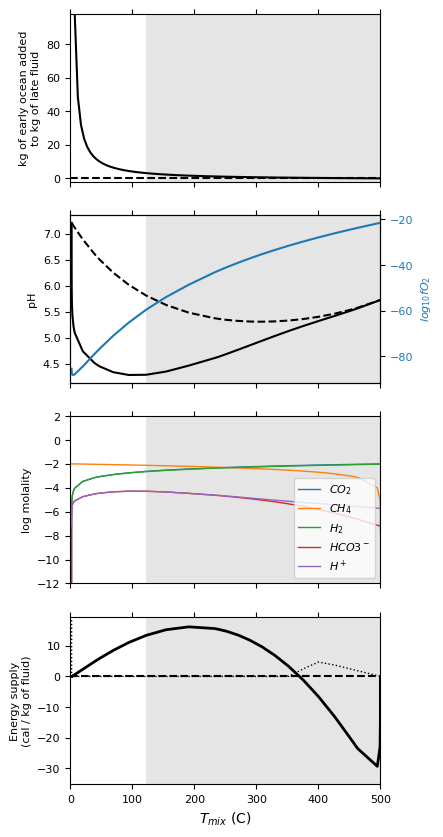

In [3]:
number = 0 # index to pick the model of interest
filename = 'ps_output_' + str(number) + '.pkl'
makeFigure3(filename, include_labels=True)

This code block below reads the pkl data into a Pandas DataFrame, which can be used to inspect the data directly.

In [4]:
# save nominal model DataFrame
df_m = getDF('ps_output_0.pkl')
with open('df_model_' + str(number) +'.pkl', 'wb') as file: 
        # A new file will be created 
        pickle.dump(df_m, file)

In [5]:
df_m

,Xi,Mass ratio,Temp(C),Press(bars),pH,log fO2,CO2,CH4,H2,HCO3-,H+,E (cal/kg fluid),Emin (cal/kg fluid)
0,0.000000e+00,1.000000e+08,2.00,1000.0,7.2139,-85.453,-16.6182,-2.0000,-6.1563,-15.6288,-7.2137,-0.0000,0.000442
1,1.000000e-08,1.000000e+07,2.00,1000.0,7.2135,-85.453,-11.0320,-2.0000,-6.1562,-10.0429,-7.2134,0.0000,0.000442
2,1.000000e-07,1.000000e+06,2.00,1000.0,7.2106,-85.454,-10.0293,-2.0000,-6.1557,-9.0432,-7.2105,0.0000,0.000443
3,1.000000e-06,1.000000e+05,2.00,1000.0,7.1817,-85.464,-9.0032,-2.0000,-6.1504,-8.0459,-7.1816,0.0000,0.000448
4,1.000000e-05,1.200711e+04,2.00,1000.0,6.9348,-85.561,-7.7880,-2.0000,-6.1013,-7.0775,-6.9347,0.0002,0.000502
5,8.328400e-05,1.000000e+04,2.04,1000.0,6.3251,-86.092,-6.4342,-2.0000,-5.8293,-6.3328,-6.3248,0.0048,0.000938
6,1.000000e-04,3.154315e+03,2.05,1000.0,6.2717,-86.176,-6.3259,-2.0000,-5.7854,-6.2777,-6.2714,0.0055,0.001038
7,3.170260e-04,1.245754e+03,2.16,1000.0,5.9536,-86.839,-5.6863,-2.0001,-5.4341,-5.9547,-5.9531,0.0148,0.002331
8,8.027270e-04,1.000000e+03,2.40,1000.0,5.7167,-87.450,-5.2146,-2.0003,-5.0837,-5.7166,-5.7160,0.0379,0.005223
9,1.000000e-03,4.093227e+02,2.50,1000.0,5.6624,-87.589,-5.1072,-2.0004,-4.9957,-5.6622,-5.6617,0.0478,0.006397
